In [1]:
! wget https://www.dropbox.com/s/2fcf4opc42r59p3/x_test32_3.npy?dl=0 -O x_test32_3.npy
! wget https://www.dropbox.com/s/ejgpruqt8zhu0j4/x_train32_3.npy?dl=0 -O x_train32_3.npy
! pip install tensorflow_addons

--2021-06-22 16:27:26--  https://www.dropbox.com/s/2fcf4opc42r59p3/x_test32_3.npy?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2fcf4opc42r59p3/x_test32_3.npy [following]
--2021-06-22 16:27:26--  https://www.dropbox.com/s/raw/2fcf4opc42r59p3/x_test32_3.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee068c275efdbccc7bf60a0657.dl.dropboxusercontent.com/cd/0/inline/BQ78PQsskz1N9-iORQpUP3R8cFNMasauc_kvYSw_R35VH8i_KkMjA6yFbu8qxKX0YTiVTTB2UNjtfP3AvPHidQUEQM9ICbFqmFIgYooT8OOy3XeL_RE9foNancYnV8zFSLBbADePaGrDCKmijxhv8vnR/file# [following]
--2021-06-22 16:27:26--  https://ucee068c275efdbccc7bf60a0657.dl.dropboxusercontent.com/cd/0/inline/BQ78PQsskz1N9-iORQpUP3R8cFNMasauc_kvYSw_R35VH8i_KkMjA6yFbu8qxKX0YTiVTTB2UNjtfP3

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,\
      MaxPool2D, Conv2D, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
IMG_SIZE=32
batch_size=200
epochs=30

In [4]:
(_, y_train), (_, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
x_train = np.load('x_train32_3.npy')
x_test = np.load('x_test32_3.npy')

In [6]:
x_train = x_train.reshape(x_train.shape[0],IMG_SIZE,IMG_SIZE,3).astype('float32')
x_test = x_test.reshape(x_test.shape[0],IMG_SIZE,IMG_SIZE,3).astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)

In [7]:
classifier = Sequential()
classifier.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE,IMG_SIZE,3)))
# classifier.add(BatchNormalization(axis=-1))  
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3,3)))
# classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))
# classifier.add(BatchNormalization(axis=-1))

classifier.add(Conv2D(64, (3,3)))
# classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))

classifier.add(Conv2D(64, (3,3)))
classifier.add(Activation('relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

classifier.add(Flatten())
# classifier.add(BatchNormalization())

classifier.add(Dense(512))
# classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.2))
classifier.add(Dense(10))
classifier.add(Activation('softmax'))

In [8]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0

In [10]:
classifier.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [11]:
train_gen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               shear_range=0.3,
                               height_shift_range=0.1,
                               zoom_range=0.1)

In [12]:
training_set = train_gen.flow(x_train,y_train,batch_size=batch_size)
test_set = train_gen.flow(x_test,y_test,batch_size=batch_size)

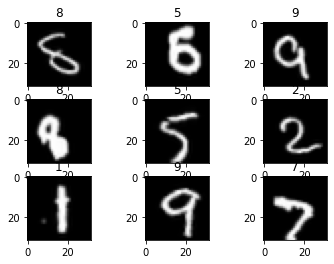

In [13]:
for i in range(9):
    img, lab = training_set.next()
    plt.subplot(3,3,i+1)
    plt.imshow(img[0])
    plt.title(np.argmax(lab[0]))

In [14]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # better than val_acc
                                               patience=4,
                                               mode='auto',
                                               verbose=1)

In [15]:
history = classifier.fit(training_set,
                         steps_per_epoch=len(x_train)//batch_size, # 300
                         validation_data=test_set,
                         validation_steps=len(x_test)//batch_size, # 50
                         epochs=epochs,
                        #  callbacks=[checkpoint_callback])
                         callbacks=[es_callback])

Epoch 1/30
300/300 [==============================] - 63s 111ms/step - loss: 0.2916 - accuracy: 0.9070 - val_loss: 0.0733 - val_accuracy: 0.9769
Epoch 2/30
300/300 [==============================] - 33s 111ms/step - loss: 0.0823 - accuracy: 0.9743 - val_loss: 0.0591 - val_accuracy: 0.9821
Epoch 3/30
300/300 [==============================] - 33s 112ms/step - loss: 0.0601 - accuracy: 0.9807 - val_loss: 0.0401 - val_accuracy: 0.9864
Epoch 4/30
300/300 [==============================] - 33s 111ms/step - loss: 0.0497 - accuracy: 0.9845 - val_loss: 0.0332 - val_accuracy: 0.9892
Epoch 5/30
300/300 [==============================] - 33s 110ms/step - loss: 0.0409 - accuracy: 0.9868 - val_loss: 0.0393 - val_accuracy: 0.9873
Epoch 6/30
300/300 [==============================] - 33s 110ms/step - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.0279 - val_accuracy: 0.9905
Epoch 7/30
300/300 [==============================] - 33s 111ms/step - loss: 0.0340 - accuracy: 0.9895 - val_loss: 0.0254 - val_ac

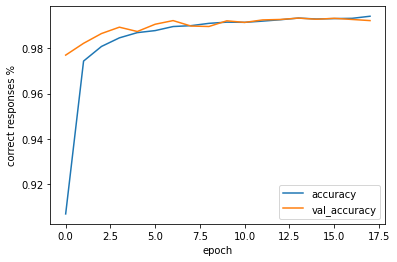

In [16]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

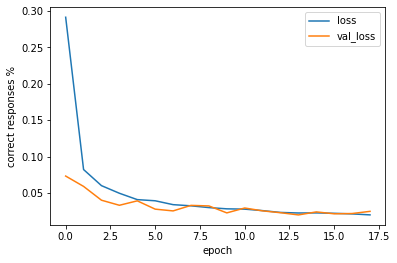

In [17]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

In [19]:
classifier.save('cnn.h5')